# Phase linking basics

In this notebook, we will walk through the basic theory of phase linking.

We'll create a synthetic stack of SLCs using the [`synth`](https://github.com/opera-adt/synth) library and write the basic functions to perform phase linking.
Then we will run the dolphin workflow on the SLCs files and view the results.

The additional dependences for this notebook (beyond the `dolphin` environment) can be installed with:

```bash
pip install pydantic-settings troposim hdf5plugin matplotlib git+https://github.com/opera-adt/synth.git 
```


## Creating synthetic SLCs

First, let's make the synthetic SLCs using the `synth` library. 

In [6]:
import json
import os
from pathlib import Path

import numpy as np

from dolphin import io, utils
import synth

In [3]:
work_dir = Path("./synthetic_slcs")
work_dir.mkdir(exist_ok=True)

os.chdir(work_dir)



In [18]:

synth_json = {
  "output_dir": ".",
  "bounding_box": [
    -117.9,
    34.95,
    -117.75,
    35.05
  ],
  "start_date": "2020-01-01T00:00:00",
  "dt": 12,
  "num_dates": 40,
  "res_y": 15.0,
  "res_x": 15.0,
  "crlb_num_looks": 121,
  "include_turbulence": True,
  "max_turbulence_amplitude": 5.0,
  "include_deformation": True,
  "max_defo_amplitude": 10.0,
  "rho_transform": "shrunk",
  "include_summed_truth": True,
  "multilook_truth": [ 5, 5 ],
  "custom_covariance": {
    "gamma_inf": 0.0,
    "tau0": 30.0,
    "gamma0": 1.0,
    "seasonal_A": None,
    "seasonal_B": None
  }
}
with open("synth-config.json", "w") as f:
    f.write(json.dumps(synth_json))

In [19]:
from synth.config import SimulationInputs
from synth.core import create_simulation_data

with open("synth-config.json") as f:
    inputs = SimulationInputs.model_validate_json(f.read())
    create_simulation_data(inputs)

2025-05-22 14:29:32,393 - synth - INFO - profile={'height': 740, 'width': 913, 'count': 1, 'compress': 'lzw', 'transform': [0.00016429353778751993, 0.0, -117.9, 0.0, -0.00013513513513512747, 35.05, 0.0, 0.0, 1.0], 'crs': 'EPSG:4326', 'driver': 'GTiff', 'dtype': 'complex64', 'interleave': 'band', 'nodata': 0.0, 'tiled': True, 'blockxsize': 256, 'blockysize': 256}
2025-05-22 14:29:32,393 - synth - INFO - shape3d = (40, 740, 913)
2025-05-22 14:29:32,394 - synth - INFO - Generating turbulence


  0%|          | 0/40 [00:00<?, ?it/s]

2025-05-22 14:29:34,997 - synth - INFO - Generating deformation


  0%|          | 0/40 [00:00<?, ?it/s]

2025-05-22 14:29:36,280 - synth - INFO - Generating ramps
2025-05-22 14:29:37,921 - synth - INFO - Simulating correlated noise


  0%|          | 0/48 [00:00<?, ?it/s]

## Inspect the simulated data

Let's make some interferograms to see what the data looks like.

In [30]:

import matplotlib.pyplot as plt
slc_file_list = sorted(Path("slcs").glob("2*.tif"))

# Load the SLC stack
reader = io.RasterStackReader.from_file_list(slc_file_list)
print(reader.shape)

(40, 740, 913)


In [31]:
def make_ifg(idx1: int, idx2: int, looks: tuple[int, int] = (9, 9)) -> np.ndarray:
    """Create an interferogram between slcs idx1 and idx1."""
    # Load complex images
    s1 = np.squeeze(reader[idx1, :, :])
    s2 = np.squeeze(reader[idx2, :, :])
    # Raw interferogram
    raw_ifg = s1 * np.conj(s2)
    # Apply looks to interferogram and power
    ifg = utils.take_looks(raw_ifg, *looks)
    pow1 = utils.take_looks(s1 * np.conj(s1), *looks)
    pow2 = utils.take_looks(s2 * np.conj(s2), *looks)
    # Normalize by coherence
    ifg = ifg / np.sqrt(pow1 * pow2)
    return ifg

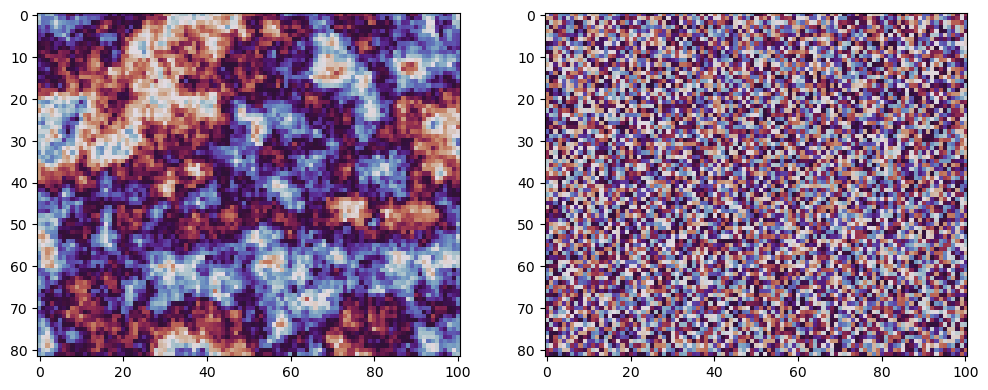

In [32]:
ifg_0_1 = make_ifg(0, 1)
ifg_0_29 = make_ifg(0, 29)

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
kw = {"vmin": -np.pi, "vmax": np.pi, "cmap": 'twilight', "interpolation": 'nearest'}
axes[0].imshow(np.angle(ifg_0_1), **kw)
axes[1].imshow(np.angle(ifg_0_29), **kw)


## Phase linking in X lines of python

 Get SLC samples into an array of shape (`nslc`, `nsamples`).

In [33]:
nslc = reader.shape[0]
half_row, half_col = (5, 5)

# Pick a row and column to process
row, col = 100, 100
sub_stack = reader[:, row - half_row:row + half_row + 1, col - half_col: col + half_col + 1].filled(0)
slc_samples = sub_stack.reshape(nslc, -1)
print(sub_stack.shape, slc_samples.shape)

(40, 11, 11) (40, 121)


Form the coherence matrix, $T \in \mathbb{C}^{N\times N}$.

The $m,n$ th element of this matrix is $\rho_{m,n}\exp (j \cdot \phi_{m,n})$, where $\rho_{m,n}$ correlation magnitude of the interferogram between image $n$ and image $n$, and $\phi_{m,n}$ is the interferometric phase.

In [34]:
# Compute un-normalized interferogram, the numerator of the complex correlation formula
ifgs = np.dot(slc_samples, np.conj(slc_samples.T))

# Compute amplitudes so we normalize the covariance to a coherence matrix
# amp_vec is shape (nslc,)
amp_vec = np.sum(np.abs(slc_samples) ** 2, axis=1)

# Form outer product of amplitudes for each slc to get an (N, N) power matrix
powers = amp_vec[:, None] * amp_vec[None, :]
amplitudes = np.sqrt(powers)

# Compute coherence matrix
coherence = ifgs / amplitudes

# (recommended: # Make the output 0 where the amplitudes are 0 (instead of nan/divide by 0)
# coherence = np.where(amplitudes > 1e-6, coherence, 0 + 0j)

Let's plot the coherence matrix for this pixel:

Text(0.5, 1.0, 'Phase')

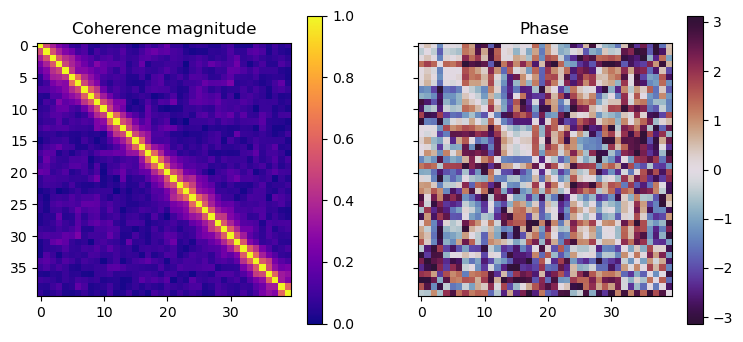

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=True, sharey=True)
axim = axes[0].imshow(np.abs(coherence), vmax=1, vmin=0, cmap='plasma')
fig.colorbar(axim, ax=axes[0])
axim = axes[1].imshow(np.angle(coherence), cmap='twilight_shifted')
fig.colorbar(axim, ax=axes[1])

axes[0].set_title("Coherence magnitude")
axes[1].set_title("Phase")


### Optimize the coherence matrix to get a phase vector

In [28]:
from scipy.linalg import eigh


def largest_eigenpair(T):
    """Get the largest eigenvalue for the "EVD/ CAESAR" method."""
    lambda_, eig_vecs = eigh(T)
    return lambda_[-1], eig_vecs[:, -1]

# reference the phases to one of the elements to remove the arbitrary offset
lambda_, V = largest_eigenpair(coherence)
V *= V[0].conj()

## Running Dolphin on the SLC stack



In [40]:
!ls

crlb_std_devs.csv input_layers      slcs              synth-config.json


In [ ]:
from dolphin.workflows import DisplacementWorkflow, displacement

cfg = DisplacementWorkflow(
    cslc_file_list=slc_file_list,
    strides={"x": 5, "y": 5},
    phase_linking={"half_window": {"x": 5, "y": 5}, "use_evd": True},
    unwrap_options={"run_unwrap": False},
    work_directory=Path("dolphin")
)

In [ ]:
displacement.run(cfg)

[INFO|displacement|L100] 2025-05-22T14:35:34-0400: Found SLC files from 1 bursts
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[INFO|wrapped_phase|L68] 2025-05-22T14:35:34-0400: Running wrapped phase estimation in /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking
[WARNING|wrapped_phase|L506] 2025-05-22T14:35:34-0400: Could not make nodata mask: /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/slcs/20210413.slc.tif is not a CSLC file
[INFO|wrapped_phase|L112] 2025-05-22T14:35:34-0400: Creating persistent scatterer file /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/PS/ps_pixels.tif
[INFO|_readers|L1088] 2025-05-22T14:35:34-0400: Processing (512, 512) sized blocks...


PS (/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/PS):   0%|          | 0/…

[INFO|ps|L159] 2025-05-22T14:35:35-0400: Waiting to write 0 blocks of data.
[INFO|ps|L162] 2025-05-22T14:35:35-0400: Repacking PS rasters for better compression
[INFO|ps|L166] 2025-05-22T14:35:35-0400: Finished writing out PS files
[INFO|ps|L299] 2025-05-22T14:35:35-0400: No striding request, skipping multilook.
[INFO|wrapped_phase|L168] 2025-05-22T14:35:35-0400: Running sequential EMI step in /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase
[INFO|sequential|L82] 2025-05-22T14:35:35-0400: File range start: 20200101.slc.tif
[INFO|sequential|L83] 2025-05-22T14:35:35-0400: File range end: 20210413.slc.tif
[INFO|sequential|L84] 2025-05-22T14:35:35-0400: Output folder: /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase
[INFO|sequential|L85] 2025-05-22T14:35:35-0400: Number of ministacks of size 15: 3
[INFO|sequential|L110] 2025-05-22T14:35:35-0400: Processing 15 SLCs. Output folder: /Users/staniewi/rep

Phase linking (/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase)…

[INFO|single|L330] 2025-05-22T14:36:04-0400: Waiting to write 19 blocks of data.
[INFO|single|L332] 2025-05-22T14:36:04-0400: Finished ministack of size (15, 740, 913).
[INFO|single|L335] 2025-05-22T14:36:05-0400: Repacking for more compression


Processing Rasters:   0%|          | 0/15 [00:00<?, ?it/s]

[INFO|single|L338] 2025-05-22T14:36:05-0400: Creating similarity raster on outputs


  0%|          | 0/4 [00:00<?, ?it/s]

[INFO|sequential|L110] 2025-05-22T14:36:09-0400: Processing 16 SLCs. Output folder: /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/20200629_20201214
[INFO|single|L85] 2025-05-22T14:36:09-0400: VRTStack(16 bands, outfile=/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/20200629_20201214.vrt): from (datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 6, 17, 0, 0)) to [datetime.datetime(2020, 12, 14, 0, 0)]
[INFO|single|L104] 2025-05-22T14:36:09-0400: Processing 15 SLCs + 1 compressed SLCs. 
[INFO|single|L109] 2025-05-22T14:36:09-0400: Total stack size (in pixels): (16, 740, 913)


Phase linking (/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase)…

[INFO|single|L330] 2025-05-22T14:36:38-0400: Waiting to write 19 blocks of data.
[INFO|single|L332] 2025-05-22T14:36:38-0400: Finished ministack of size (16, 740, 913).
[INFO|single|L335] 2025-05-22T14:36:38-0400: Repacking for more compression


Processing Rasters:   0%|          | 0/15 [00:00<?, ?it/s]

[INFO|single|L338] 2025-05-22T14:36:38-0400: Creating similarity raster on outputs


  0%|          | 0/4 [00:00<?, ?it/s]

[INFO|sequential|L110] 2025-05-22T14:36:42-0400: Processing 12 SLCs. Output folder: /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/20201226_20210413
[INFO|single|L85] 2025-05-22T14:36:42-0400: VRTStack(12 bands, outfile=/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/20201226_20210413.vrt): from (datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 6, 17, 0, 0)) to [datetime.datetime(2021, 4, 13, 0, 0)]
[INFO|single|L104] 2025-05-22T14:36:42-0400: Processing 10 SLCs + 2 compressed SLCs. 
[INFO|single|L109] 2025-05-22T14:36:42-0400: Total stack size (in pixels): (12, 740, 913)


Phase linking (/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase)…